# Generate initial designs for training data for ART

First import ART package:

In [1]:
import sys
sys.path.append('../AutomatedRecommendationTool')
    
from art.core import *

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


All genes we might consider in relation to isopentenol production:

In [2]:
genes = ['ACCOAC', 
         'POX', # zero flux, can be forced
         'PTAr', 
         'CS', 
         'ACACT1r', 
         'PPC', 
         'PPCK', # zero flux
         'PFL', # zero flux, can be forced
         'PYK', # zero flux 
         'MDH']

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

Assing numerical categories to each of the modifications:

In [3]:
modif_dict = {'KO': int(0), 
              'NoMod': int(1),
              'UP': int(2)}

As current version of ART deals only with continuous variables, we will first find recommended designs from interval [0, 3] and then transform each of those to one of defined categories {0, 1, 2} using the `floor` function.

`bounds.csv` file contains minimum/maximum values for intervals from which each of the genes can take values

In [19]:
bounds_filename = './data/bounds.csv'

How many genes you want to consider?

In [4]:
n_genes = int(input())


 8


How many instances you want to generate?

In [5]:
n_instances = int(input())

 100


In [6]:
n_modifications = len(modif_dict)
genes = genes[:n_genes]
tot_number_mod = n_modifications**n_genes
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 6561
Training set size: 100 (1.52%)


Next define a dictionary that contains all of the settings that ART will use to find the recommended designs:

In [7]:
art_params = {}
art_params['input_var'] = genes[:n_genes]
art_params['num_recommendations'] = n_instances - 1
art_params['initial_cycle'] = True
art_params['bounds_file'] = bounds_filename
art_params['seed'] = 10
art_params['output_directory'] = './art_files'


Generate recommendations by running ART:

In [8]:
art = RecommendationEngine(**art_params)
df = art.recommendations.copy()
df.head()

,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
0,0.795864,1.785400,1.700735,0.574367,0.821748,1.552047,2.071725,1.280729
1,0.178965,0.034494,2.033663,2.441166,0.397357,2.103414,1.270302,2.422635
2,1.395676,2.442114,2.886140,1.564969,1.281542,2.910813,0.951475,1.573435
3,1.294897,1.926222,2.082841,0.599307,1.134819,2.709709,0.552649,2.892046
4,2.564929,2.737152,2.388253,2.652497,0.999300,1.237677,1.917104,0.430165


Define wild type strain with no modifications:

In [9]:
df.loc[n_instances-1] = [modif_dict['NoMod'] for i in range(n_genes)] 
df.tail()

,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
95,1.356240,0.131644,0.127225,1.671634,2.493955,1.798121,0.237461,1.004275
96,2.276131,0.609370,1.099147,1.018763,1.864967,2.129163,1.863582,0.823852
97,0.474742,0.079694,2.148171,1.533104,2.882027,1.342870,2.804676,1.256627
98,2.380387,0.014347,0.742153,0.736493,0.599110,0.159264,0.930103,1.506594
99,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Transform the values for designs back to categories (0, 1 or 2):

In [10]:
df = np.floor(df)
df.tail()

,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
95,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0
96,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0
97,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0
98,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Create Line Names:

In [11]:
df.insert(loc=0, column='Line Name', value=[str(i) for i in range(1,n_instances)]+['WT'])
df.tail()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
95,96,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0
96,97,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0
97,98,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0
98,99,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99,WT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


How many modifications 'introduced' into each strain?

In [12]:
def num_of_modifications(df):
    num_instances = len(df)
    values = np.empty(num_instances)
    for i in range(num_instances):
        design = df.loc[i][1:]
        values[i] = list(design).count(0) + list(design).count(2)
    return values
            

In [13]:
df['# Modifs'] = num_of_modifications(df)
df.tail()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL,# Modifs
95,96,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,4.0
96,97,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,4.0
97,98,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,5.0
98,99,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0
99,WT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Find distribution of modifications per gene in the training data set:

In [14]:
df.loc[n_instances] = ['Summary'] + [[list(df[gene]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for gene in genes] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name               Summary
ACCOAC       [33.0, 34.0, 33.0]
POX          [33.0, 34.0, 33.0]
PTAr         [33.0, 34.0, 33.0]
CS           [33.0, 34.0, 33.0]
ACACT1r      [33.0, 34.0, 33.0]
PPC          [33.0, 34.0, 33.0]
PPCK         [33.0, 34.0, 33.0]
PFL          [33.0, 34.0, 33.0]
# Modifs                   5.28
Name: 100, dtype: object

In [15]:
def plot_distribution(dataframe): 
    bar_height = 1
    labels = ['KO', 'NoMod', 'UP']
    colors = ['#019600', 'grey', '#219AD8']

    data = [ [dataframe[dataframe['Line Name']=='Summary'][g].values[0][num] for g in genes] 
            for num in range(n_modifications)]
    y_pos = np.arange(len(genes))

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)

    # Remove frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    patch_handles = []
    # left alignment of data starts at zero
    left = np.zeros(len(genes)) 
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
                                     color=colors[i%len(colors)], edgecolor='white',
                                     height=bar_height, align='center', 
                                     left=left, label=labels[i]))
        left += d

    # search all of the bar segments and annotate
    for j in range(n_modifications):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, "%d%%" % (data[j][i]), ha='center')

    ax.set_title('Distribution of modifications')
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', 
                    labelbottom='off')
    plt.yticks(y_pos, genes)
    ax.invert_yaxis()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


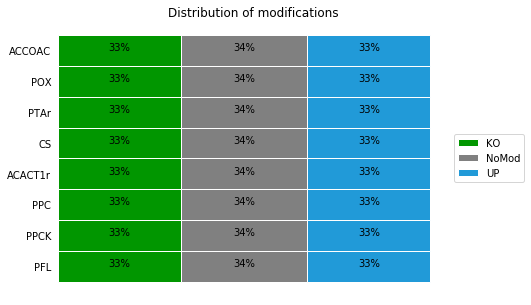

In [16]:
plot_distribution(df)

Save training set:

In [18]:
data_filename = f'./data/training_data_{n_genes}genes_ART.csv'
df.loc[0:(n_instances-1)].to_csv(data_filename, 
                                 columns = ['Line Name'] + genes, 
                                 header = True, index = False)